<a href="https://colab.research.google.com/github/Dominika26/classification_tutorials_public/blob/main/Classify_Songs_Genres_From_Audio_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Read in track metadata with genre labels
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('echonest-metrics.json', precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[['track_id' , 'genre_top']], how='inner', on='track_id')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


**2. Pairwise relationships between continous variables**

We typically want to avoid using variables that have strong correlations with each other, hence avoiding feature redundancy for a few reasons:
- To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
When our datasets are very large, using fewer features can drastically speed up our computation time.
- To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the pandas package.

In [4]:
# prepare a correlation matrix 
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


There is not much strong correlation between any features, we do not need to remove any feature from our data 

**3. Normalizing the feature data**

Since we didn’t find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).
It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.
However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through standardization, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).

In [5]:
#Define our features 
features = echo_tracks.drop(['track_id', 'genre_top'], axis=1)

#define our labels 
labels = echo_tracks.genre_top

#scale the features and set the values to a new variable 
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

In [7]:
#data after standarization
pd.DataFrame(scaled_train_features).head(5)

,0,1,2,3,4,5,6,7
0,-0.191210,1.304420,0.038316,-1.576494,-0.068755,0.373034,1.153979,0.462287
1,-0.306036,0.501886,0.788176,-1.599809,-0.545463,2.446155,0.007914,-0.690811
2,-1.204813,1.684139,0.312852,-1.602876,1.229828,0.135130,-0.777317,0.631077
3,-0.094655,0.417927,-0.265203,-1.553079,-0.607326,2.882707,-0.364657,1.652859
4,1.361706,-0.985896,1.453323,0.979975,-0.442757,-0.364157,-1.072003,-1.573102


**4. Prinicipal component analysis on our scaled data**

Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use scree-plots and cumulative explained ratio plots to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an ‘elbow’ (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.


Text(0.5, 0, 'Principal component')

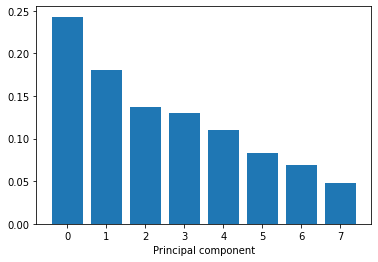

In [9]:
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

#plot the explained variance
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal component')

There does not appear a clear elbow in this scree plot 

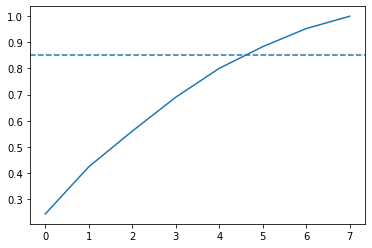

In [10]:
# Calculate the cumulative explained variance 
cum_exp_variance = np.cumsum(exp_variance)

#plot the cumulative explained variance and draw a dashed line at 0.85
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

We can use the lower dimensional PCA projection of the data to classify songs into genres. 

**5. Splittig data and training a decision tree**

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

#train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)



DecisionTreeClassifier(random_state=10)

**6. Compare decision tree to a logistic regression**


In [15]:
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



Both models are similiarly well. However we can see that rock song are fairly well classified, but hip-hop songs are misclassidied as rock songs.

Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model’s ability to distinguish between classes. This also tells us that most of our model’s accuracy is driven by its ability to classify just rock songs, which is less than ideal.

**7. Balance our data for greater performance**

we only need to account for differences in the sample size of our data points when weighing our classes here, and not relative importance of each class.

In [16]:
# Subset a balanced proportiion of data points 
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

**8. Does balancing our dataset improve model bias?**

In [17]:
# Train our data decision tree on the balanced data
tree = DecisionTreeClassifier()
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression()
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_tree))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.74      0.74       230
        Rock       0.73      0.74      0.74       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.74      0.74       230
        Rock       0.73      0.74      0.74       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455



Balaning our data removed bias towards the more prelevant class. We can also apply cross-validation, this allows us to compare models in more rigorous fashion.

**9. Using cross-validation to ealuate our models**

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what’s known as K-fold cross-validation here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.

In [18]:
# set up our K-fold cross-validation 
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# train our model using KFold cv 
tree_score = cross_val_score(tree,pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg,pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", tree_score, "Logistic Regression:", logit_score)

Decision Tree: [0.6978022  0.72527473 0.78021978 0.70879121 0.71428571 0.75274725
 0.76923077 0.71978022 0.78021978 0.84065934] Logistic Regression: [0.76923077 0.80769231 0.82417582 0.76923077 0.76923077 0.78021978
 0.77472527 0.74175824 0.7967033  0.7967033 ]


Now, that we have performed k fold cross-validation on our dataset, we can be pretty sure that our model will generalize 72% of the times on the future unseen data points. 